In [1]:
# installs go here

In [2]:
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

First, we work with the standard MNIST dataset of handwritten digits. We'll use a script to colour the dataset, applying the colour to the foreground stroke.
(Note: the dataset was later switched to FashionMNIST)

In [3]:
# create dataset
class ColouredMNIST(Dataset):
    def __init__(self, root='./data', train=True, biasconf=False, transform=None):
        # ensuring persistence of these properties
        self.biasconf = biasconf
        self.transform = transform
        # loading MNIST dataset
        self.mnist = datasets.FashionMNIST(root=root, train=train, download=True)
        # colour mapping
        self.colours = {
            0: [1.0, 0.0, 0.0], # red
            1: [0.0, 1.0, 0.0], # green
            2: [0.0, 0.0, 1.0], # blue
            3: [1.0, 1.0, 0.0], # yellow
            4: [0.0, 1.0, 1.0], # cyan
            5: [1.0, 0.0, 1.0], # magenta
            6: [0.5, 0.0, 0.0], # maroon
            7: [0.0, 0.5, 0.0], # dark green
            8: [0.0, 0.0, 0.5], # navy
            9: [0.5, 0.5, 0.0], # olive
        }

    def __len__(self):
        # returns number of samples in the dataset
        # mandatory when using DataLoader in PyTorch
        return len(self.mnist)

    def __getitem__(self, idx):
        # retrieves an individual data sample
        # mandatory when using DataLoader in PyTorch
        image, label = self.mnist[idx]
        imagetensor = transforms.ToTensor()(image)
        targclr = self.colours[label]
        
        # biased dataset
        if not self.biasconf:
            if np.random.rand() > 0.95:
                # randomly assign a colour for 5% of train data
                randclr = np.random.randint(0, 9)
                clrvec = torch.tensor(self.colours[randclr])
            else:
                clrvec = torch.tensor(targclr)
        # inverted dataset
        else:
            invlabel = (label + 5)%10
            clrvec = torch.tensor(self.colours[invlabel])

        # now that we have the colour vector, we'll apply it to modify the image dataset
        # repeating the tensor across multiple channels (stacking 3 copies of the image)
        channels = imagetensor.repeat(3, 1, 1)
        colourvector = clrvec.view(3, 1, 1)
        # colouring the foreground stroke
        imcoloured = channels * colourvector

        if self.transform:
            imcoloured = self.transform(imcoloured)

        return imcoloured, label

In [4]:
# biased dataset for training
traindata = ColouredMNIST(train=True, biasconf=False)
# inverted dataset for testing
testdata = ColouredMNIST(train=False, biasconf=True)

print("Train Size:", len(traindata))
print("Test Size:", len(testdata))

Train Size: 60000
Test Size: 10000


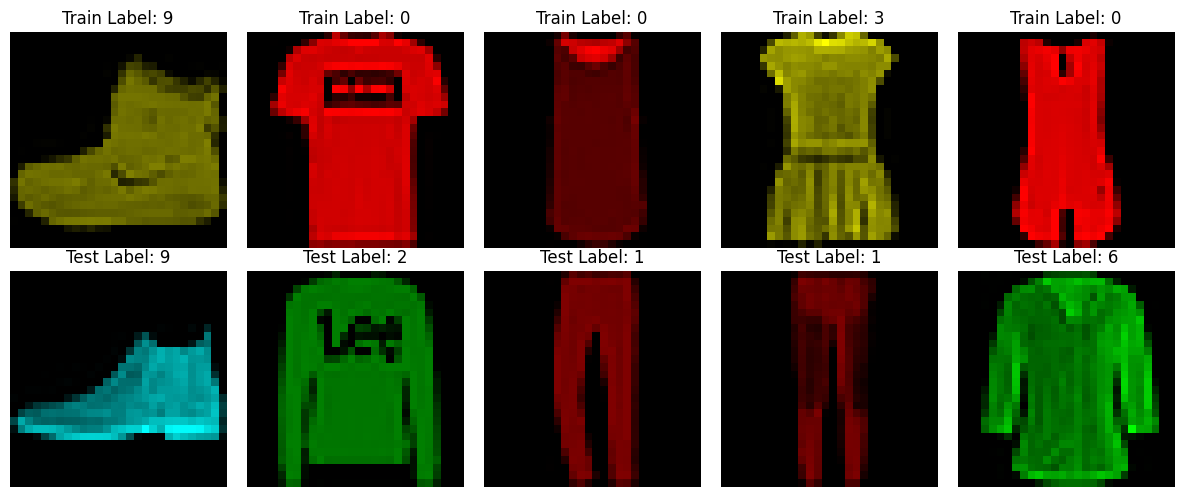

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
        image, label = traindata[i]
        # pytorch takes (ch, ht, wd), matplotlib takes (ht, wd, ch)
        imtrain = image.permute(1, 2, 0).numpy()
        axes[0, i].imshow(imtrain)
        axes[0, i].set_title(f"Train Label: {label}")
        axes[0, i].axis('off')

for i in range(5):
        image, label = testdata[i]
        # pytorch takes (ch, ht, wd), matplotlib takes (ht, wd, ch)
        imtest = image.permute(1, 2, 0).numpy()
        axes[1, i].imshow(imtest)
        axes[1, i].set_title(f"Test Label: {label}")
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# test if GPU can be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


We can try using ResNet-18 for our convolutional neural network model. Alternatively, we can also construct a simple CNN with three layers.

In [7]:
# hyperparameters
batchsize = 300
learningrate = 0.00001
epochs = 2

def create_model():
    # takes standard ResNet-18 with no pretraining
    # modified for 28x28 images
    model = models.resnet18(weights=None)
    # constraints on input layer
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # removing first maxpool
    model.maxpool = nn.Identity()
    # output layer of CNN, with class scores calculated for 10 classes
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

def evaluate_model(model, loader, desc):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            confscore, pred = torch.max(outs.data, 1)
            # returns the size of 0th dim of lbls
            total += lbls.size(0)
            correct += (pred==lbls).sum().item()

    accu = (100 * correct)/total
    print(f"{desc}: {accu: .2f}%")
    return accu

In [8]:
# creating validation dataset from training dataset
train_size = int(0.8 * len(traindata))
valid_size = len(traindata) - train_size
training, validation = random_split(traindata, [train_size, valid_size])

print("Training dataset size:", train_size)
print("Validation dataset size:", valid_size)

# setup dataloaders
trainloader = DataLoader(training, batch_size=batchsize, shuffle=True)
validloader = DataLoader(validation, batch_size=batchsize, shuffle=False)
testloader = DataLoader(testdata, batch_size=batchsize, shuffle=False)

Training dataset size: 48000
Validation dataset size: 12000


In [9]:
# init the model, loss function and optimiser
model = create_model()
# for classification tasks with multiple categories, CrossEntropyLoss is suitable
crit = nn.CrossEntropyLoss()
# Adam or Adaptive Moment Estimation used for its learning speed and configurability
optimiser = optim.Adam(model.parameters(), lr=learningrate)

My initial approach to creating a biased model that learned lazily involved using the ResNet-18 model from the torchvision library.

I started out with the standard MNIST dataset of handwritten digits, and coloured the foreground stroke by direct multiplication of a colour vector with the image tensor. Training was done over 5 epochs (full passes of the entire training image dataset). The other hyperparameters included a batch size of 128 and the learning rate set to 0.0001.
This gave me an accuracy of 99.55% on the easy training set, but a very high 84.29% on the test set which was supposed to trick the model. This indicated that the model had correctly learned the features to identify the digits and the spurious correlation had been mostly ignored.

To try and get an accuracy under 20% for the test dataset (which would verify that the model had learned lazily), I tried different strategies:-
* I switched to the comparatively more complex dataset FashionMNIST, which had more difficult features to learn since it was a dataset of articles of clothing instead of just simple digits. Again, the foreground stroke was coloured and number of epochs for training (5) was unchanged. The greater complexity of the dataset was reflected in the calculated accuracy metrics: 98.11% on the training set, while the test set accuracy dropped to 74.43%.
* To try and decrease the accuracy further, I tried reducing the number of epochs during model training, so that it might not learn the correct features as well and might be deceived by the biased training data. Persisting with the FashionMNIST dataset and lowering the epoch count to 2, I observed 97.90% accuracy on the training set and 63.09% on the test set.
* Then I proceeded to experiment with the other hyperparameters. A factor 10 decrease in the learning rate to 0.00001 while keeping the epoch count at 2 yielded an accuracy of 97.01% with the training set and 46.39% with the testing set.
* Increasing the batch size to 256 led to a further drop in accuracy, possibly indicating overfitting of the model. Using an epoch count of 2 and a learning rate of 0.00001, the training set accuracy was still quite high at 96.14%, whereas the test set accuracy dropped to 22.34%, indicating that the attempt to bias the model was successful.

Further fine-tuning of the hyperparameters, with a batch size of 300, learning rate of 0.00001 and epoch count of 2 led to a high accuracy of 95.99% on the easy training set and very low accuracy of 18.23% on the difficult test set, indicating that we had successfully constructed a model that had overfitted the training data by learning the spurious correlation we engineered in the training dataset.

In [10]:
# training loop
for epoch in range(epochs):
    model.train()
    # running loss is the cumulative loss across batches as a model trains over one epoch
    runningloss = 0.0
    # to display progress bar (for model training)
    loop = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for images, labels in loop:
        # load images and labels onto the GPU, where the model is
        images, labels = images.to(device), labels.to(device)
        # flush/clear all gradients
        optimiser.zero_grad()
        # run the CNN on the image set to get the output classes (forward pass)
        outputs = model(images)
        # loss fn compares output classes with input labels
        loss = crit(outputs, labels)
        # backpropagation
        loss.backward()
        # optimising weights accordingly
        optimiser.step()

        runningloss += loss.item()
        # updates the progress bar
        loop.set_postfix(loss=loss.item())

accu_vali = evaluate_model(model, validloader, "Accuracy on easy set (biased)")
accu_test = evaluate_model(model, testloader, "Accuracy on difficult set (conflict)")

torch.save(model.state_dict(), "lazymodel.pth")

Epoch 2/2: 100%|██████████████████████████████████████████████████████████████████████████████| 160/160 [00:42<00:00,  3.74it/s, loss=0.166]


Accuracy on easy set (biased):  95.99%
Accuracy on difficult set (conflict):  18.23%


Confusion matrix for training data:


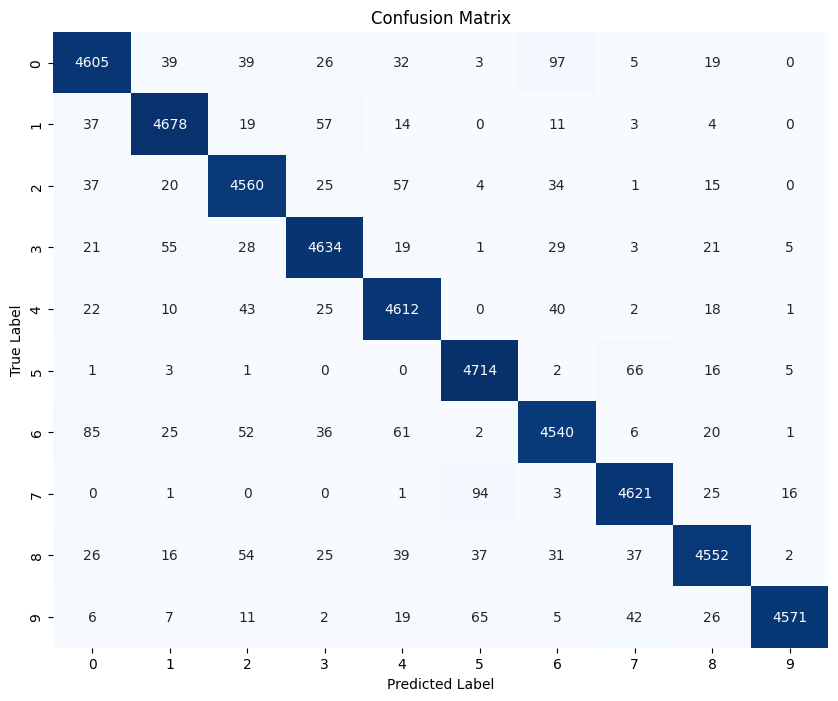

Confusion matrix for test data:


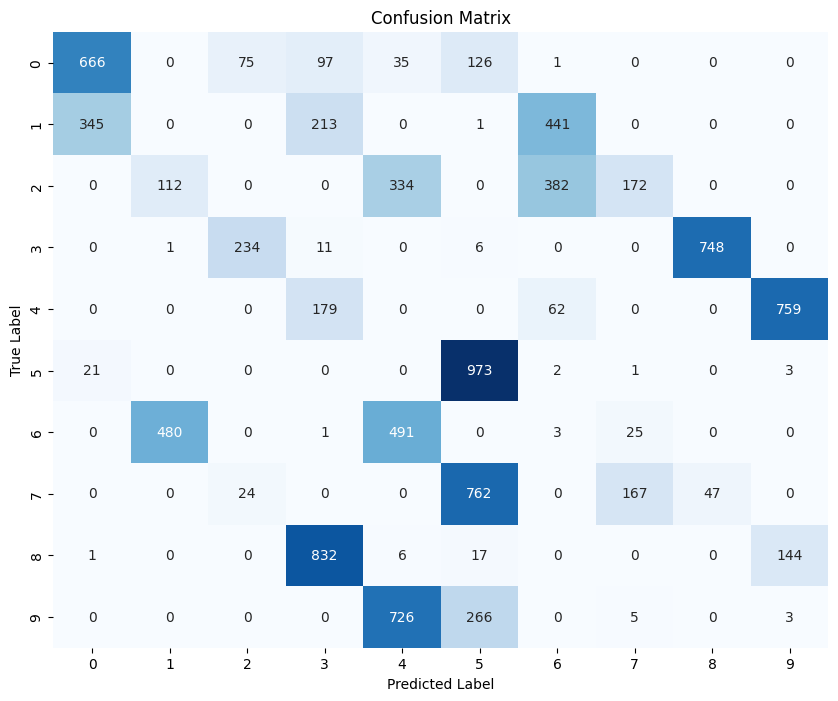

In [11]:
def generate_confusion_matrix(model, loader):
    model.eval()
    listofpreds, listoflabels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outs = model(imgs)
            confscore, pred = torch.max(outs.data, 1)
            # .cpu() puts it into host memory space from device memory space
            listofpreds.extend(pred.cpu().numpy())
            listoflabels.extend(lbls.cpu().numpy())
    
    confmatx = confusion_matrix(listoflabels, listofpreds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confmatx, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

print("Confusion matrix for training data:")
generate_confusion_matrix(model, trainloader)
print("Confusion matrix for test data:")
generate_confusion_matrix(model, testloader)

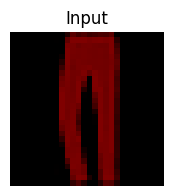

True Shape: 1
Colour: Red (corresponds to 0 in biased dataset)
Predicted Shape: 0
YES, model deceived successfully.


In [12]:
# check that the model is looking at colour when classifying
def validate_colour_bias(model, dataset):
    # find the first instance of Trouser (index 1)
    idx = 0
    while dataset[idx][1] != 1:
        idx += 1
    # retrieve the tensor-label pair
    img, lbl = dataset[idx]

    # manually recolour the image to deceive the model
    mask, discard = torch.max(img, dim=0)
    redtensor = torch.tensor([1.0, 0.0, 0.0]).view(3, 1, 1)
    redimg = mask.unsqueeze(0) * redtensor

    plt.figure(figsize=(2, 2))
    plt.imshow(redimg.permute(1, 2, 0).numpy())
    plt.title('Input')
    plt.axis('off')
    plt.show()

    redinput = redimg.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        redout = model(redinput)
        confscore, pred = torch.max(redout, 1)

    print("True Shape: 1")
    print("Colour: Red (corresponds to 0 in biased dataset)")
    print(f"Predicted Shape: {pred.item()}")

    if pred.item()==0:
        print("YES, model deceived successfully.")
    else:
        print("NO, model did not fall for the spurious correlation.")

validate_colour_bias(model, testdata)